# 코로나19 한국 사망율 시계열 분석

#### 출처 : https://kdx.kr/data/view/25918

## Goal

지난 2020년 코로나 바이러스가 한국에 들어온 이후 오늘까지도 우리의 일생에 큰 영향을 끼치고 있다.  
코로나 바이러스의 경우 사망율은 낮지만, 높은 전파력과 후휴증이 심한 것이 문제였다. 사망율 마저도 노년층에서는 높은 비율을 보였다.  이 노트북에서는 다음의 사항을 살펴볼 예정이다.  
1. 2020년 이후의 코로나 사망율 추이와 연령대 별 사망율을 분석한다. 
2. 백신 개발 이후 사망율에 변화가 있는지 살펴봄으로서 백신의 효용성을 따져보려고 한다.   
    2-1. 확진율에 변화가 있을까?
3. 시계열 예측 방법을 사용해 앞으로 코로나 진행이 어떻게 될 지를 살펴본다.

지금까지 코로나 바이러스는 대규모 확산과 감소세를 반복했다. 완전한 일상 복귀를 코앞에 둔 이 시점에 우리는 어떻게 미래를 대비하면 좋을지 데이터를 통해 살펴보자.

## 1. 전체 사망율과 연령대별 사망율 분석

In [1]:
import pandas as pd
import numpy as np
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
from matplotlib import gridspec
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
covid_age = pd.read_csv('../data/covid_korea/Covid19GenAgeCaseInf.csv')

### 1-1 데이터 살펴보기

In [3]:
covid_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10673 entries, 0 to 10672
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   seq           10673 non-null  int64  
 1   gubun         10673 non-null  object 
 2   confCase      10673 non-null  int64  
 3   confCaseRate  10673 non-null  float64
 4   death         9184 non-null   float64
 5   deathRate     10610 non-null  float64
 6   criticalRate  9007 non-null   object 
 7   createDt      10673 non-null  object 
 8   updateDt      4 non-null      object 
dtypes: float64(3), int64(2), object(4)
memory usage: 750.6+ KB


9개의 columns와 총 10673개의 rows가 있는 걸 확인했다.  
death와 deathRate, criticalRate의 경우 Null 값이 많다.  
데이터를 본격적으로 살펴보기 전에 결측치 처리를 수행한다.



In [4]:
covid_age[covid_age['death'].isnull() == True]

,seq,gubun,confCase,confCaseRate,death,deathRate,criticalRate,createDt,updateDt
3775,14814,10-19,119709,12.33,NaN,0.0,NaN,2022-02-05 10:38:55.858,NaN
3786,14792,10-19,114276,12.23,NaN,0.0,NaN,2022-02-04 09:00:31.605,NaN
3797,14770,10-19,109905,12.11,NaN,0.0,0.00,2022-02-03 08:47:50.424,NaN
3808,14737,10-19,105994,11.99,NaN,0.0,NaN,2022-02-02 09:11:50.525,NaN
3819,14715,10-19,102319,11.84,NaN,0.0,NaN,2022-02-01 09:15:19.052,NaN
...,...,...,...,...,...,...,...,...,...
10652,21,10-19,544,5.27,NaN,NaN,NaN,2020-04-07 19:32:08.08,NaN
10653,20,20-29,2819,27.29,NaN,NaN,NaN,2020-04-07 19:32:08.08,NaN
10662,11,0-9,112,1.14,NaN,NaN,NaN,2020-04-02 19:02:48.48,NaN
10663,10,10-19,515,5.26,NaN,NaN,NaN,2020-04-02 19:02:48.48,NaN


사망자에 대한 결측치는 사망자가 없는 경우, 즉 0인 경우 NaN으로 표현한 것 같다. 이 결측치에 대해서는 0으로 채우자.

In [5]:
covid_age['death'].fillna(0, inplace=True)
covid_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10673 entries, 0 to 10672
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   seq           10673 non-null  int64  
 1   gubun         10673 non-null  object 
 2   confCase      10673 non-null  int64  
 3   confCaseRate  10673 non-null  float64
 4   death         10673 non-null  float64
 5   deathRate     10610 non-null  float64
 6   criticalRate  9007 non-null   object 
 7   createDt      10673 non-null  object 
 8   updateDt      4 non-null      object 
dtypes: float64(3), int64(2), object(4)
memory usage: 750.6+ KB


In [6]:
# deathRate에 대한 결측치 확인
covid_age[covid_age['deathRate'].isnull() ==True].head(50)

,seq,gubun,confCase,confCaseRate,death,deathRate,criticalRate,createDt,updateDt
2839,16731,0-9,2103959,12.0,19.0,NaN,NaN,2022-05-01 09:16:02.781,NaN
2840,16730,10-19,2267050,13.0,8.0,NaN,NaN,2022-05-01 09:16:02.781,NaN
2841,16729,20-29,2482423,14.0,52.0,NaN,NaN,2022-05-01 09:16:02.781,NaN
2842,16728,30-39,2544163,15.0,100.0,NaN,NaN,2022-05-01 09:16:02.781,NaN
2850,16709,0-9,2100431,12.0,19.0,NaN,NaN,2022-04-30 09:19:06.075,NaN
2851,16708,10-19,2263296,13.0,8.0,NaN,NaN,2022-04-30 09:19:06.074,NaN
2852,16707,20-29,2477181,14.0,52.0,NaN,NaN,2022-04-30 09:19:06.074,NaN
2853,16706,30-39,2539011,15.0,99.0,NaN,NaN,2022-04-30 09:19:06.074,NaN
3147,16093,0-9,1739783,13.0,13.0,NaN,NaN,2022-04-03 09:13:24.62,NaN
3148,16092,10-19,1877777,14.0,4.0,NaN,NaN,2022-04-03 09:13:24.62,NaN


In [7]:
covid_age[covid_age['deathRate'].isnull() ==True].tail(50)

,seq,gubun,confCase,confCaseRate,death,deathRate,criticalRate,createDt,updateDt
3159,16081,10-19,1849793,14.00,4.0,NaN,NaN,2022-04-02 09:41:18.967,NaN
3160,16080,20-29,1994289,15.00,42.0,NaN,NaN,2022-04-02 09:41:18.967,NaN
3161,16079,30-39,2014832,15.00,85.0,NaN,NaN,2022-04-02 09:41:18.967,NaN
3422,15541,0-9,631994,12.00,5.0,NaN,NaN,2022-03-09 09:13:08.947,NaN
3423,15540,10-19,716737,14.00,2.0,NaN,NaN,2022-03-09 09:13:08.947,NaN
3424,15539,20-29,854612,16.00,22.0,NaN,NaN,2022-03-09 09:13:08.947,NaN
3532,15310,0-9,353331,12.00,5.0,NaN,NaN,2022-02-27 09:04:25.955,NaN
3533,15309,10-19,410879,14.00,1.0,NaN,NaN,2022-02-27 09:04:25.954,NaN
3534,15308,20-29,511132,17.00,17.0,NaN,NaN,2022-02-27 09:04:25.954,NaN
3543,15299,0-9,332047,12.00,5.0,NaN,NaN,2022-02-26 09:25:31.612,NaN


daethRate가 NaN인 이유를 분명히 알기는 어렵지만, 확연히 눈에 띄는 특성이 있다면 바로 확진자와 사망자가 매우 적은 시기라는 점이다. 이 경우 사망율을 구하면 그 수치가 과하게 높게 나올 가능성이 있다.  
사망율이 NaN인 값은 각 나이별 평균 사망율로 체우자.

In [8]:
# 나이별 평균 사망율 구하기.
covid_age.groupby('gubun')['deathRate'].mean()


gubun
0-11      1.000000
0-9       0.029800
10-19     0.012223
20-29     0.146376
30-39     0.501967
40-49     1.120278
50-59     4.508093
60-69    12.725351
70-79    26.928835
80 이상    53.962928
남성       50.464624
여성       49.533887
Name: deathRate, dtype: float64

In [9]:
covid_age[covid_age['gubun'] == '0-11']

,seq,gubun,confCase,confCaseRate,death,deathRate,criticalRate,createDt,updateDt
10650,23,0-11,1,1.0,1.0,1.0,1,2020-04-07 20:10:50.50,NaN


한 행에 대해서만 이런 카테고리가 적용된 것으로 보아 오류인 듯 보인다.  
index 10650 앞뒤로 데이터를 살펴보자.

In [10]:
covid_age.iloc[10645: 10655]

,seq,gubun,confCase,confCaseRate,death,deathRate,criticalRate,createDt,updateDt
10645,28,60-69,1312,12.63,27.0,13.50,2.06,2020-04-08 10:55:38.38,NaN
10646,27,70-79,692,6.66,60.0,30.00,8.67,2020-04-08 10:55:38.38,NaN
10647,26,80 이상,470,4.53,96.0,48.00,20.43,2020-04-08 10:55:38.38,NaN
10648,25,여성,6221,59.91,94.0,47.00,1.51,2020-04-08 10:55:38.38,NaN
10649,24,남성,4163,40.09,106.0,53.00,2.55,2020-04-08 10:55:38.38,NaN
10650,23,0-11,1,1.00,1.0,1.00,1,2020-04-07 20:10:50.50,NaN
10651,22,0-9,126,1.22,0.0,NaN,NaN,2020-04-07 19:32:08.08,NaN
10652,21,10-19,544,5.27,0.0,NaN,NaN,2020-04-07 19:32:08.08,NaN
10653,20,20-29,2819,27.29,0.0,NaN,NaN,2020-04-07 19:32:08.08,NaN
10654,19,30-39,1092,10.57,1.0,0.52,0.09,2020-04-07 19:32:08.08,NaN


20년 4월 7일 날자에 0-11은 잘못 입력된 데이터로 보인다. 삭제해도 될 것 같다.

In [11]:
covid_age.drop(covid_age.index[[10650]], axis=0, inplace=True)
covid_age.reset_index(drop=True, inplace=True)
covid_age.iloc[10645: 10655]

,seq,gubun,confCase,confCaseRate,death,deathRate,criticalRate,createDt,updateDt
10645,28,60-69,1312,12.63,27.0,13.50,2.06,2020-04-08 10:55:38.38,NaN
10646,27,70-79,692,6.66,60.0,30.00,8.67,2020-04-08 10:55:38.38,NaN
10647,26,80 이상,470,4.53,96.0,48.00,20.43,2020-04-08 10:55:38.38,NaN
10648,25,여성,6221,59.91,94.0,47.00,1.51,2020-04-08 10:55:38.38,NaN
10649,24,남성,4163,40.09,106.0,53.00,2.55,2020-04-08 10:55:38.38,NaN
10650,22,0-9,126,1.22,0.0,NaN,NaN,2020-04-07 19:32:08.08,NaN
10651,21,10-19,544,5.27,0.0,NaN,NaN,2020-04-07 19:32:08.08,NaN
10652,20,20-29,2819,27.29,0.0,NaN,NaN,2020-04-07 19:32:08.08,NaN
10653,19,30-39,1092,10.57,1.0,0.52,0.09,2020-04-07 19:32:08.08,NaN
10654,18,40-49,1382,13.38,2.0,1.04,0.14,2020-04-07 19:32:08.08,NaN


head로 데이터 일부를 살펴보자.

In [12]:
covid_age.head(10)

,seq,gubun,confCase,confCaseRate,death,deathRate,criticalRate,createDt,updateDt
0,22861,0-9,3061098,10.2,37.0,0.1,0.00,2023-01-19 00:21:59.0,NaN
1,22860,10-19,3743925,12.5,20.0,0.1,0.00,2023-01-19 00:21:59.0,NaN
2,22859,20-29,4360900,14.6,78.0,0.2,0.00,2023-01-19 00:21:59.0,NaN
3,22858,30-39,4375308,14.6,152.0,0.5,0.00,2023-01-19 00:21:59.0,NaN
4,22857,40-49,4563317,15.2,449.0,1.4,0.01,2023-01-19 00:21:59.0,NaN
5,22856,50-59,3904007,13.0,1355.0,4.1,0.03,2023-01-19 00:21:59.0,NaN
6,22855,60-69,3255917,10.9,3760.0,11.4,0.12,2023-01-19 00:21:59.0,NaN
7,22854,70-79,1658042,5.5,7499.0,22.7,0.45,2023-01-19 00:21:59.0,NaN
8,22853,80 이상,1005444,3.4,19754.0,59.7,1.96,2023-01-19 00:21:59.0,NaN
9,22852,여성,16054424,53.6,16855.0,50.9,0.10,2023-01-19 00:21:59.0,NaN


위 데이터를 살펴보면 createDt가 모두 23년 01월 19일임을 알 수 있고, gubun(구분)에서 연령대 카테고리를 형성하고 있다.  
좀 더 많은 rows를 살펴보자.

In [13]:
covid_age.head(20)

,seq,gubun,confCase,confCaseRate,death,deathRate,criticalRate,createDt,updateDt
0,22861,0-9,3061098,10.20,37.0,0.10,0.00,2023-01-19 00:21:59.0,NaN
1,22860,10-19,3743925,12.50,20.0,0.10,0.00,2023-01-19 00:21:59.0,NaN
2,22859,20-29,4360900,14.60,78.0,0.20,0.00,2023-01-19 00:21:59.0,NaN
3,22858,30-39,4375308,14.60,152.0,0.50,0.00,2023-01-19 00:21:59.0,NaN
4,22857,40-49,4563317,15.20,449.0,1.40,0.01,2023-01-19 00:21:59.0,NaN
5,22856,50-59,3904007,13.00,1355.0,4.10,0.03,2023-01-19 00:21:59.0,NaN
6,22855,60-69,3255917,10.90,3760.0,11.40,0.12,2023-01-19 00:21:59.0,NaN
7,22854,70-79,1658042,5.50,7499.0,22.70,0.45,2023-01-19 00:21:59.0,NaN
8,22853,80 이상,1005444,3.40,19754.0,59.70,1.96,2023-01-19 00:21:59.0,NaN
9,22852,여성,16054424,53.60,16855.0,50.90,0.10,2023-01-19 00:21:59.0,NaN


데이터를 살펴보면, 0세 부터 80세 이상까지 카테고리와 남성, 여성 카테고리가 모두 한 날짜에 묶여있다.  
연령대별 일일 데이터를 얻기 위해서는 이 데이터를 쪼갤 필요가 있을 것 같다. 우리는 성별 데이터는 사용하지 않을 것이므로 이는 무시한다.

### 1-2 연령대로 데이터 분리

연령대 데이터를 어떻게 나눌 수 있을까?  
판다스에서 제공하는 조건문으로 gubun이 같은 데이터로 있는 데이터만 추출하여 따로 저장하면 될 것 같다.

In [14]:
zero = covid_age[covid_age['gubun'] == '0-9']
zero.head(10)

,seq,gubun,confCase,confCaseRate,death,deathRate,criticalRate,createDt,updateDt
0,22861,0-9,3061098,10.20,37.0,0.10,0.00,2023-01-19 00:21:59.0,NaN
11,22839,0-9,3059405,10.23,37.0,0.11,0,2023-01-18 05:59:48.0,NaN
22,22828,0-9,3057496,10.24,37.0,0.11,0.00,2023-01-17 03:56:19.0,NaN
33,22795,0-9,3055413,10.25,37.0,0.11,0,2023-01-16 01:35:39.0,NaN
44,22773,0-9,3054348,10.20,37.0,0.10,0.00,2023-01-15 01:20:23.0,NaN
55,22751,0-9,3052602,10.25,37.0,0.11,0,2023-01-14 09:37:10.0,NaN
66,22729,0-9,3052602,10.25,37.0,0.11,0,2023-01-14 05:52:23.0,NaN
77,22707,0-9,3050664,10.26,37.0,0.11,0.00,2023-01-13 05:09:26.0,NaN
88,22663,0-9,3048555,10.27,37.0,0.11,0,2023-01-12 06:03:14.0,NaN
99,22652,0-9,3046322,10.30,37.0,0.10,0.00,2023-01-11 05:56:40.0,NaN


연령대별 데이터가 날자로 잘 모여있는 것을 확인했다. 나머지 연령대도 같은 작업을 진행하자.

In [15]:
ten = covid_age[covid_age['gubun']=='10-19']
twenty = covid_age[covid_age['gubun']=='20-29']
thirty = covid_age[covid_age['gubun']=='30-39']
forty = covid_age[covid_age['gubun']=='40-49']
fifty = covid_age[covid_age['gubun']=='50-59']
sixty = covid_age[covid_age['gubun']=='60-69']
seventy = covid_age[covid_age['gubun']=='70-79']
eighty = covid_age[covid_age['gubun']=='80 이상']


위에서 처리하지 못했던 연령별 결측치를 제거하자.  
결측치를 평균 사망율로 대체한다.

In [16]:
# 연령대별 사망율을 구하기 위해 원 데이터에서 성별 행을 삭제하자.

covid_age = covid_age[(covid_age['gubun'] != '남성') & (covid_age['gubun'] != '여성')]
covid_age.groupby('gubun')['deathRate'].mean()

gubun
0-9       0.029800
10-19     0.012223
20-29     0.146376
30-39     0.501967
40-49     1.120278
50-59     4.508093
60-69    12.725351
70-79    26.928835
80 이상    53.962928
Name: deathRate, dtype: float64

In [17]:
# 결측치 처리
zero['deathRate'] = covid_age[covid_age['gubun']=='0-9']['deathRate'].fillna(0.03, )
ten['deathRate'] = covid_age[covid_age['gubun']=='10-19']['deathRate'].fillna(0.01, )
twenty['deathRate'] = covid_age[covid_age['gubun']=='20-29']['deathRate'].fillna(0.15, )
thirty['deathRate'] = covid_age[covid_age['gubun']=='30-39']['deathRate'].fillna(0.5, )
forty['deathRate'] = covid_age[covid_age['gubun']=='40-49']['deathRate'].fillna(1.12, )
fifty['deathRate'] = covid_age[covid_age['gubun']=='50-59']['deathRate'].fillna(4.5, )
sixty['deathRate'] = covid_age[covid_age['gubun']=='60-69']['deathRate'].fillna(12.72, )
seventy['deathRate'] = covid_age[covid_age['gubun']=='70-79']['deathRate'].fillna(26.92, )
eighty['deathRate'] = covid_age[covid_age['gubun']=='80 이상']['deathRate'].fillna(53.96, )

간단히 플롯으로 연령대별 사망율 추이를 살펴보자.

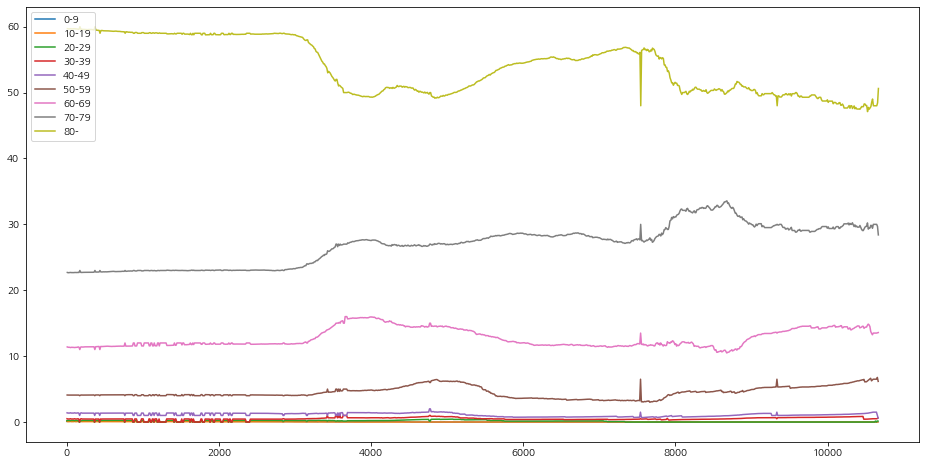

In [18]:
plt.figure(figsize=(16, 8))
plt.plot(zero.deathRate, label='0-9')
plt.plot(ten.deathRate, label='10-19')
plt.plot(twenty.deathRate, label='20-29')
plt.plot(thirty.deathRate, label='30-39')
plt.plot(forty.deathRate, label='40-49')
plt.plot(fifty.deathRate, label='50-59')
plt.plot(sixty.deathRate, label='60-69')
plt.plot(seventy.deathRate, label='70-79')
plt.plot(eighty.deathRate, label='80-') 
plt.legend()
plt.show()

그래프를 살펴보면 연령대별 사망율이 극명하게 차이나는 것을 볼 수 있다.  
나이가 들 수록 사망율이 기하급수적으로 증가함을 볼 수 있다.
평균 사망율을 일별로 살펴보자. 이를 위해 createDt 정보에서 시간 단위를 제거하고 연월일 정보만 남기자.

In [19]:
covid_age['createDt'] = covid_age['createDt'].apply(lambda x: x[:10])
covid_age['createDt'].head(5)

0    2023-01-19
1    2023-01-19
2    2023-01-19
3    2023-01-19
4    2023-01-19
Name: createDt, dtype: object

In [20]:
# 일별 평균 사망율
covid_age.groupby(['createDt']).deathRate.mean()

createDt
2020-04-02    16.668333
2020-04-07    16.666667
2020-04-08    11.904762
2020-04-09    11.111111
2020-04-10    11.111111
                ...    
2023-01-15    11.122222
2023-01-16    11.111111
2023-01-17    11.112222
2023-01-18    11.112222
2023-01-19    11.133333
Name: deathRate, Length: 958, dtype: float64

일별 사망율을 살펴보니 데이터가 이상하다. 평균이 대부분 11%에서 머물러 있다.  
데이터를 다시 살펴보자.

In [21]:
eighty.head(10)

,seq,gubun,confCase,confCaseRate,death,deathRate,criticalRate,createDt,updateDt
8,22853,80 이상,1005444,3.40,19754.0,59.70,1.96,2023-01-19 00:21:59.0,NaN
19,22831,80 이상,1003889,3.36,19727.0,59.68,1.97,2023-01-18 05:59:48.0,NaN
30,22820,80 이상,1001469,3.35,19702.0,59.68,1.97,2023-01-17 03:56:19.0,NaN
41,22787,80 이상,999576,3.35,19683.0,59.67,1.97,2023-01-16 01:35:39.0,NaN
52,22765,80 이상,998803,3.40,19660.0,59.70,1.97,2023-01-15 01:20:23.0,NaN
63,22743,80 이상,996944,3.35,19636.0,59.66,1.97,2023-01-14 09:37:10.0,NaN
74,22721,80 이상,996944,3.35,19636.0,59.66,1.97,2023-01-14 05:52:23.0,NaN
85,22699,80 이상,994755,3.35,19618.0,59.69,1.97,2023-01-13 05:09:26.0,NaN
96,22655,80 이상,992615,3.34,19587.0,59.68,1.97,2023-01-12 06:03:14.0,NaN
107,22644,80 이상,990333,3.30,19537.0,59.70,1.97,2023-01-11 05:56:40.0,NaN


데이터를 살펴보니 confCase(확진 수)와 death(사망자) 데이터가 일별이 아닌 누적이다. 사망율도 변동이 거의 없는 것을 보아 신규 확진자/ 신규 사망자에 대한 신규 사망율은 아닌 것으로 보인다. 이래서는 시계열 데이터로 분석이 어렵다. 누적 데이터를 차분해서 신규 확진자와 사망자를 구해보자.

이를 위해 원 데이터에서 불필요한 열들을 제거하고 다시 나이별로 변수를 만들자.

In [22]:
# 불필요한 데이터 제거
print(covid_age.columns)

Index(['seq', 'gubun', 'confCase', 'confCaseRate', 'death', 'deathRate',
       'criticalRate', 'createDt', 'updateDt'],
      dtype='object')


필요 없는 columns를 제거한다.  
seq : 고유값 - 제거
criticalRate : 치명율 ( Null 값이 너무 많다) - 제거
updateDt : 데이터를 수정한 날짜 - 제거

In [23]:
covid_age.drop(['seq', 'criticalRate', 'updateDt'], axis=1, inplace=True)

이제 차분을 통해 각 나이대별 데이터프레임에 신규 확진자, 신규 사망자 그리고 이를 나눈 신규 사망율을 구하자. 차분을 진행하기 전에 해당 데이터는 날자에 대해 내림차순이므로 차분을 그냥 진행하면 값이 모두 음수가 나올 것이다. 그래서 먼저 index를 역순으로 재배열하자.

In [24]:
covid_age = covid_age.loc[::-1]
covid_age.head()

,gubun,confCase,confCaseRate,death,deathRate,createDt
10669,80 이상,442,4.52,82.0,50.62,2020-04-02
10668,70-79,651,6.65,46.0,28.40,2020-04-02
10667,60-69,1235,12.62,22.0,13.58,2020-04-02
10666,50-59,1851,18.91,10.0,6.17,2020-04-02
10665,40-49,1312,13.41,1.0,0.62,2020-04-02


In [25]:
covid_age[covid_age.death.isnull() == True]

,gubun,confCase,confCaseRate,death,deathRate,createDt


차분을 진행하기 위해 역순으로 재배열된 데이터를 연령별 데이터로 다시 만들자.

In [101]:
zero = covid_age[covid_age['gubun']=='0-9'].drop(['gubun'], axis=1).reset_index(drop=True)
ten = covid_age[covid_age['gubun']=='10-19'].drop(['gubun'], axis=1).reset_index(drop=True)
twenty = covid_age[covid_age['gubun']=='20-29'].drop(['gubun'], axis=1).reset_index(drop=True)
thirty = covid_age[covid_age['gubun']=='30-39'].drop(['gubun'], axis=1).reset_index(drop=True)
forty = covid_age[covid_age['gubun']=='40-49'].drop(['gubun'], axis=1).reset_index(drop=True)
fifty = covid_age[covid_age['gubun']=='50-59'].drop(['gubun'], axis=1).reset_index(drop=True)
sixty = covid_age[covid_age['gubun']=='60-69'].drop(['gubun'], axis=1).reset_index(drop=True)
seventy = covid_age[covid_age['gubun']=='70-79'].drop(['gubun'], axis=1).reset_index(drop=True)
eighty = covid_age[covid_age['gubun']=='80 이상'].drop(['gubun'], axis=1).reset_index(drop=True)

In [102]:

# 결측치 처리
zero['deathRate'] = zero['deathRate'].fillna(0.03)
ten['deathRate'] = ten['deathRate'].fillna(0.01)
twenty['deathRate'] = twenty['deathRate'].fillna(0.15)
thirty['deathRate'] = thirty['deathRate'].fillna(0.5)
forty['deathRate'] = forty['deathRate'].fillna(1.12)
fifty['deathRate'] = fifty['deathRate'].fillna(4.5)
sixty['deathRate'] = sixty['deathRate'].fillna(12.72)
seventy['deathRate'] = seventy['deathRate'].fillna(26.92)
eighty['deathRate'] = eighty['deathRate'].fillna(53.96)

In [103]:
zero.head()

,confCase,confCaseRate,death,deathRate,createDt
0,112,1.14,0.0,0.03,2020-04-02
1,126,1.22,0.0,0.03,2020-04-07
2,126,1.21,0.0,0.00,2020-04-08
3,126,1.21,0.0,0.03,2020-04-08
4,126,1.21,0.0,0.00,2020-04-08


In [104]:
# Null값 확인
zero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   confCase      971 non-null    int64  
 1   confCaseRate  971 non-null    float64
 2   death         971 non-null    float64
 3   deathRate     971 non-null    float64
 4   createDt      971 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 38.1+ KB


In [105]:
zero['newConfCase'] = zero['confCase'].diff(1)
ten['newConfCase'] = ten['confCase'].diff(1)
twenty['newConfCase'] = twenty['confCase'].diff(1)
thirty['newConfCase'] = thirty['confCase'].diff(1)
forty['newConfCase'] = forty['confCase'].diff(1)
fifty['newConfCase'] = fifty['confCase'].diff(1)
sixty['newConfCase'] = sixty['confCase'].diff(1)
seventy['newConfCase'] = seventy['confCase'].diff(1)
eighty['newConfCase'] = eighty['confCase'].diff(1)

In [106]:
zero.head()

,confCase,confCaseRate,death,deathRate,createDt,newConfCase
0,112,1.14,0.0,0.03,2020-04-02,NaN
1,126,1.22,0.0,0.03,2020-04-07,14.0
2,126,1.21,0.0,0.00,2020-04-08,0.0
3,126,1.21,0.0,0.03,2020-04-08,0.0
4,126,1.21,0.0,0.00,2020-04-08,0.0


conf와 death가 누적이라면 차분 데이터에서 음수는 발생할 수 없다.  
음수가 존재하는지 살펴보자.

In [107]:
zero[zero['newConfCase'] < 0]

,confCase,confCaseRate,death,deathRate,createDt,newConfCase
27,140,1.30,0.0,0.0,2020-04-27,-1.0
104,221,1.64,0.0,0.0,2020-07-16,-1.0
276,2440,3.59,0.0,0.0,2021-01-17,-209.0
284,126,1.21,0.0,0.0,2021-01-24,-2670.0


이 데이터의 앞뒤를 모두 살펴보자. 

In [108]:
zero.iloc[27-1:27+2]

,confCase,confCaseRate,death,deathRate,createDt,newConfCase
26,141,1.31,0.0,0.0,2020-04-26,2.0
27,140,1.30,0.0,0.0,2020-04-27,-1.0
28,140,1.30,0.0,0.0,2020-04-28,0.0


In [109]:
zero.iloc[104-1:104+2]

,confCase,confCaseRate,death,deathRate,createDt,newConfCase
103,222,1.64,0.0,0.0,2020-07-15,1.0
104,221,1.64,0.0,0.0,2020-07-16,-1.0
105,231,1.69,0.0,0.0,2020-07-17,10.0


In [110]:
zero.iloc[276-1:276+2]

,confCase,confCaseRate,death,deathRate,createDt,newConfCase
275,2649,3.69,0.0,0.0,2021-01-16,31.0
276,2440,3.59,0.0,0.0,2021-01-17,-209.0
277,2676,3.70,0.0,0.0,2021-01-18,236.0


In [111]:
zero.iloc[284-1:284+2]

,confCase,confCaseRate,death,deathRate,createDt,newConfCase
283,2796,3.74,0.0,0.0,2021-01-23,21.0
284,126,1.21,0.0,0.0,2021-01-24,-2670.0
285,2828,3.74,0.0,0.0,2021-01-25,2702.0


대충 몇개의 데이터 이상치를 살펴보니 데이터 입력부터 잘못됐을 것으로 보인다.  
이에 대한 해결책으로 차분한 값이 음수면 그냥 0으로 치환한다.

그럼 데이터 클랜징을 진행하자.

In [112]:
zero[zero['newConfCase'] < 0] = 0
ten[ten['newConfCase'] < 0] = 0
twenty[twenty['newConfCase'] < 0] = 0
thirty[thirty['newConfCase'] < 0] = 0
forty[forty['newConfCase'] < 0] = 0
fifty[fifty['newConfCase'] < 0] = 0
sixty[sixty['newConfCase'] < 0] = 0
seventy[seventy['newConfCase'] < 0] = 0
eighty[eighty['newConfCase'] < 0] = 0

In [113]:
zero[zero['newConfCase'] < 0]

,confCase,confCaseRate,death,deathRate,createDt,newConfCase


사망자에 대해서도 차분을 진행해 신규 사망자를 구하자.


In [114]:
zero['newDeath'] = zero['death'].diff(1)
ten['newDeath'] = ten['death'].diff(1)
twenty['newDeath'] = twenty['death'].diff(1)
thirty['newDeath'] = thirty['death'].diff(1)
forty['newDeath'] = forty['death'].diff(1)
fifty['newDeath'] = fifty['death'].diff(1)
sixty['newDeath'] = sixty['death'].diff(1)
seventy['newDeath'] = seventy['death'].diff(1)
eighty['newDeath'] = eighty['death'].diff(1)

In [115]:
ten.head()

,confCase,confCaseRate,death,deathRate,createDt,newConfCase,newDeath
0,515,5.26,0.0,0.01,2020-04-02,NaN,NaN
1,544,5.27,0.0,0.01,2020-04-07,29.0,0.0
2,548,5.28,0.0,0.00,2020-04-08,4.0,0.0
3,548,5.28,0.0,0.01,2020-04-08,0.0,0.0
4,548,5.28,0.0,0.00,2020-04-08,0.0,0.0


확진자와 마찬가지로 음수 데이터를 살펴보자.

In [116]:
zero[zero['newConfCase'] < 0]

,confCase,confCaseRate,death,deathRate,createDt,newConfCase,newDeath


In [117]:
ten[ten['newConfCase'] < 0]

,confCase,confCaseRate,death,deathRate,createDt,newConfCase,newDeath


In [118]:
twenty[twenty['newConfCase'] < 0]

,confCase,confCaseRate,death,deathRate,createDt,newConfCase,newDeath


In [119]:
zero[zero['newDeath'] < 0] = 0
ten[ten['newDeath'] < 0] = 0
twenty[twenty['newDeath'] < 0] = 0
thirty[thirty['newDeath'] < 0] = 0
forty[forty['newDeath'] < 0] = 0
fifty[fifty['newDeath'] < 0] = 0
sixty[sixty['newDeath'] < 0] = 0
seventy[seventy['newDeath'] < 0] = 0
eighty[eighty['newDeath'] < 0] = 0

In [120]:
zero[zero['newConfCase'] < 0]

,confCase,confCaseRate,death,deathRate,createDt,newConfCase,newDeath


차분을 진행하면 첫번째 열은 값이 존재하지 않게 된다. 따라서 첫번째 행은 분석을 위해 제거하자.

In [121]:
zero=zero.drop(index=0, axis=0).reset_index(drop=True)
ten=ten.drop(index=0, axis=0).reset_index(drop=True)
twenty=twenty.drop(index=0, axis=0).reset_index(drop=True)
thirty=thirty.drop(index=0, axis=0).reset_index(drop=True)
forty=forty.drop(index=0, axis=0).reset_index(drop=True)
fifty=fifty.drop(index=0, axis=0).reset_index(drop=True)
sixty=sixty.drop(index=0, axis=0).reset_index(drop=True)
seventy=seventy.drop(index=0, axis=0).reset_index(drop=True)
eighty=eighty.drop(index=0, axis=0).reset_index(drop=True)

In [122]:
zero.head()

,confCase,confCaseRate,death,deathRate,createDt,newConfCase,newDeath
0,126,1.22,0.0,0.03,2020-04-07,14.0,0.0
1,126,1.21,0.0,0.00,2020-04-08,0.0,0.0
2,126,1.21,0.0,0.03,2020-04-08,0.0,0.0
3,126,1.21,0.0,0.00,2020-04-08,0.0,0.0
4,126,1.21,0.0,0.00,2020-04-08,0.0,0.0


새롭게 얻은 데이터로 신규 사망율 column을 추가하자.

In [123]:
zero['newDeathRate'] = round(zero['newDeath'] / zero['newConfCase'], 3)
ten['newDeathRate'] = round(ten['newDeath'] / ten['newConfCase'], 3)
twenty['newDeathRate'] = round(twenty['newDeath'] / twenty['newConfCase'], 3)
thirty['newDeathRate'] = round(thirty['newDeath'] / thirty['newConfCase'], 3)
forty['newDeathRate'] = round(forty['newDeath'] / forty['newConfCase'], 3)
fifty['newDeathRate'] = round(fifty['newDeath'] / fifty['newConfCase'], 3)
sixty['newDeathRate'] = round(sixty['newDeath'] / sixty['newConfCase'], 3)
seventy['newDeathRate'] = round(seventy['newDeath'] / seventy['newConfCase'], 3)
eighty['newDeathRate'] = round(eighty['newDeath'] / eighty['newConfCase'], 3)

나이별 사망율 데이터를 살펴보자.

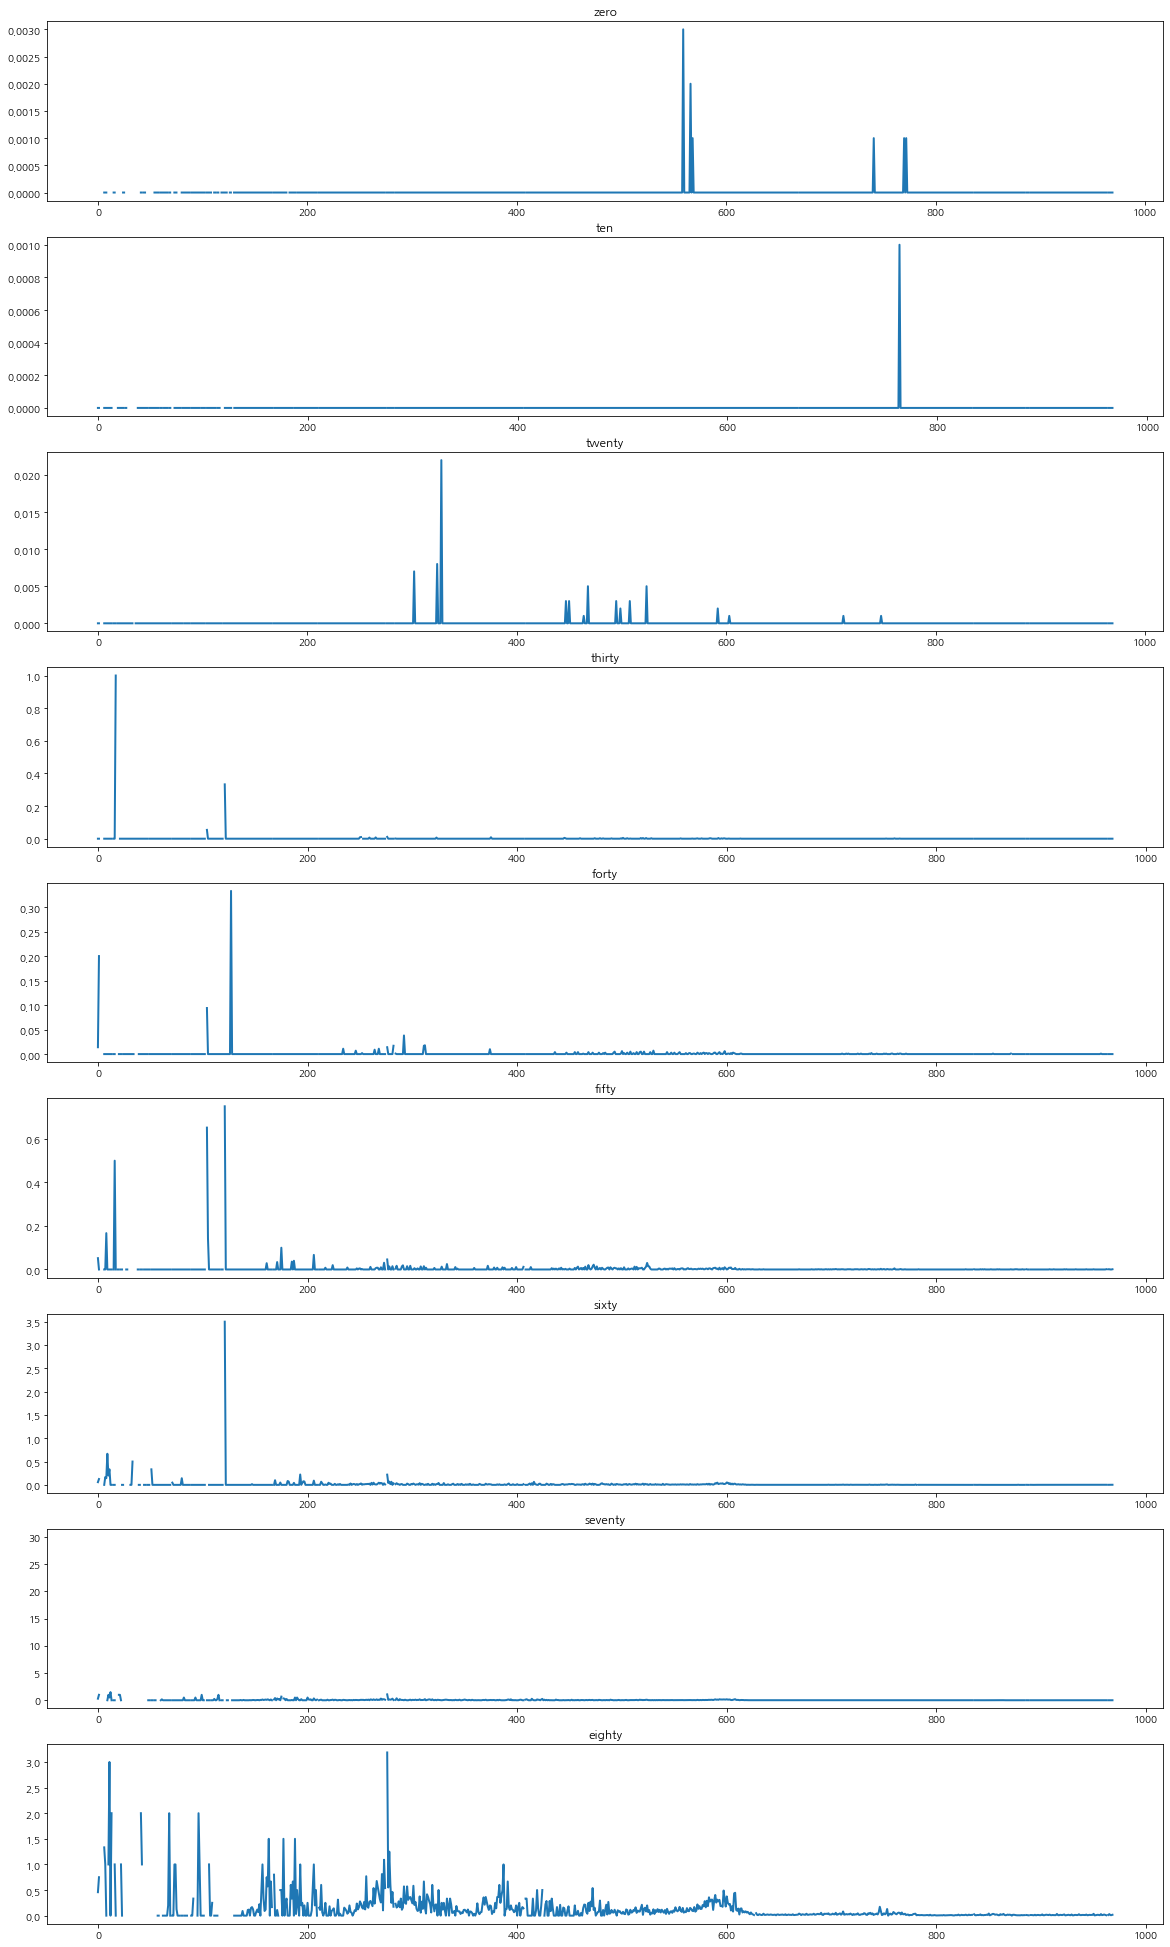

In [124]:
ages = ['zero', 'ten', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty'][::-1]


fig, axs = plt.subplots(9, 1, figsize=(20, 35))
# fig.suptitle("연령대 별 사망율 추이")
axs[0].plot(zero.newDeathRate, label='0-9', linestyle='-', linewidth='2')
axs[1].plot(ten.newDeathRate, label='10-19', linestyle='-', linewidth='2')
axs[2].plot(twenty.newDeathRate, label='20-29', linestyle='-', linewidth='2')
axs[3].plot(thirty.newDeathRate, label='30-39', linestyle='-', linewidth='2')
axs[4].plot(forty.newDeathRate, label='40-49', linestyle='-', linewidth='2')
axs[5].plot(fifty.newDeathRate, label='50-59', linestyle='-', linewidth='2')
axs[6].plot(sixty.newDeathRate, label='60-69', linestyle='-', linewidth='2')
axs[7].plot(seventy.newDeathRate, label='70-79', linestyle='-', linewidth='2')
axs[8].plot(eighty.newDeathRate, label='80-', linestyle='-', linewidth='2') 
for i in range(9):
    axs[i].set_title(ages.pop())
plt.show()

y 범위가 과도하게 높은 데이터를 살펴보면 inf가 존재한다. 이런 값들은 모두 0으로 치환하자.

In [128]:
sixty[sixty['newDeathRate'] == np.inf] = 0
seventy[seventy['newDeathRate'] == np.inf] = 0
eighty[eighty['newDeathRate'] == np.inf] = 0

전처리는 이쯤하기로 한다. 마무리된 데이터를 내보내자.

In [129]:
zero.to_csv('../data/covid_korea/age_new_data/ageDf_0.csv', )
ten.to_csv('../data/covid_korea/age_new_data/ageDf_10.csv', )
twenty.to_csv('../data/covid_korea/age_new_data/ageDf_20.csv', )
thirty.to_csv('../data/covid_korea/age_new_data/ageDf_30.csv', )
forty.to_csv('../data/covid_korea/age_new_data/ageDf_40.csv', )
fifty.to_csv('../data/covid_korea/age_new_data/ageDf_50.csv', )
sixty.to_csv('../data/covid_korea/age_new_data/ageDf_60.csv', )
seventy.to_csv('../data/covid_korea/age_new_data/ageDf_70.csv', )
eighty.to_csv('../data/covid_korea/age_new_data/ageDf_80.csv', )

아유~ 고생했다.